##### fmode-detectability.ipynb
### *astrophysical constraints on neutron-star fundamental-mode oscillations*

this notebook calculates the f-mode dynamical tide distinguishability snr for a population of binary neutron star coalescences and plots the distinguishability threshold as a function of neutron star masses

##### philippe landry (pgjlandry@gmail.com) 09/2024

In [17]:
# import packages

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import json
import h5py
import sys
from tqdm import tqdm

sys.path.insert(0,'/home/philippe.landry/bilby/')
import bilby

bilby.core.utils.setup_logger(log_level=0)

from Matplotlib_settings import mpl_settings
mpl_settings()

In [2]:
# define physical constants

G = 6.674e-8
c = 2.998e10
Msun = 1.988e33

In [3]:
# load posterior samples in f-mode frequency vs mass sequences

DATA_DIR = 'LCEHL_EOS_posterior_samples_PSR+GW+NICER/eos_'
DATA_EXT = '.json'

def DATA_PATH(i):
    return DATA_DIR+str(i)+DATA_EXT

with open(DATA_PATH(0), 'r') as infile: # peek at the data structure
    data = json.load(infile)
print(list(data.keys()))

['Nc', 'Ec', 'Pc', 'M', 'Mp', 'Mb', 'Eg', 'Et', 'A', 'R', 'C', 'k2', 'Lambda', 'NRO_GR']


In [4]:
# specify settings for posterior samples

NSAMP = int(1e4) # number of posterior samples
MMIN, MMAX = (0.8, 3.0) # global minimum and maximum masses for sequences

In [5]:
# interpolate f(m) functions from f-mode frequency vs mass sequences

f_of_ms = []
warns = []

for i in range(NSAMP):
    
    try:
        with open(DATA_PATH(i), 'r') as infile: # skip missing samples
            data = json.load(infile)
    except:
        warns += [i]
        continue

    ms = np.array(data['M'])
    fs = np.array(data['NRO_GR']['f'])

    mmax_idx = np.argmax(ms) # maximum mass in sequence
    mmin_idx = np.argmin(ms) # minimum mass in sequence
    submmins = np.where(ms<MMIN)[0] # masses in sequence below global MMIN
    if len(submmins) > 0: mmin_idx = max(mmin_idx,submmins[-1]+1) # truncate sequence at larger of mmin or MMIN

    ms = ms[mmin_idx:mmax_idx+1]
    fs = fs[mmin_idx:mmax_idx+1]

    f_of_ms += [interp1d(ms,fs,bounds_error=False, fill_value=np.nan)] # interpolate f(m), returning nan where extrapolation occurs

#print('warning: {0} samples missing, including sample {1}!'.format(len(warns),warns[0]))

In [6]:
# interpolate R(m) and Lambda(m) functions from sequences

infile = h5py.File('../gpeos-data-release/LCEHL_EOS_posterior_samples_PSR+GW+NICER.h5', 'r')

mseqs = [infile['ns']['eos_{0}'.format(i)]['M'] for i in range(NSAMP) if i not in warns]
Lseqs = [infile['ns']['eos_{0}'.format(i)]['Lambda'] for i in range(NSAMP) if i not in warns]
Rseqs = [infile['ns']['eos_{0}'.format(i)]['R'] for i in range(NSAMP) if i not in warns]

L_of_ms, R_of_ms = [], []

for ms,Ls,Rs in zip(mseqs,Lseqs,Rseqs):

    mmax_idx = np.argmax(ms) # maximum mass in sequence
    mmin_idx = np.argmin(ms) # minimum mass in sequence
    submmins = np.where(ms<MMIN)[0] # masses in sequence below global MMIN
    if len(submmins) > 0: mmin_idx = max(mmin_idx,submmins[-1]+1) # truncate sequence at larger of mmin or MMIN

    ms = ms[mmin_idx:mmax_idx+1]
    Ls = Ls[mmin_idx:mmax_idx+1]
    Rs = Rs[mmin_idx:mmax_idx+1]

    L_of_ms += [interp1d(ms,Ls,bounds_error=False, fill_value=0.)] # interpolate Lambda(m), returning nan where extrapolation occurs
    R_of_ms += [interp1d(ms,Rs,bounds_error=False, fill_value=np.nan)] # interpolate R(m), returning nan where extrapolation occurs

In [7]:
# specify mass model

MMIN_POP, MMAX_POP = (1.,2.3) # maximum and minimum mass in the population
NPOP = int(16) # number of mass samples to draw from the population

mApops = np.linspace(MMIN_POP,MMAX_POP,NPOP) # assume uniform mass distribution, sampled on grid
mBpops = np.linspace(MMIN_POP,MMAX_POP,NPOP)

fApops = np.array([np.nanmean([f_of_m(mApop) for f_of_m in f_of_ms]) for mApop in mApops]) # mean f(m) relation
fBpops = np.array([np.nanmean([f_of_m(mBpop) for f_of_m in f_of_ms]) for mBpop in mBpops])

LApops = np.array([np.nanmean([L_of_m(mApop) for L_of_m in L_of_ms]) for mApop in mApops]) # mean f(m) relation
LBpops = np.array([np.nanmean([L_of_m(mBpop) for L_of_m in L_of_ms]) for mBpop in mBpops])

RApops = np.array([np.nanmean([R_of_m(mApop) for R_of_m in R_of_ms]) for mApop in mApops]) # mean R(m) relation
RBpops = np.array([np.nanmean([R_of_m(mBpop) for R_of_m in R_of_ms]) for mBpop in mBpops])

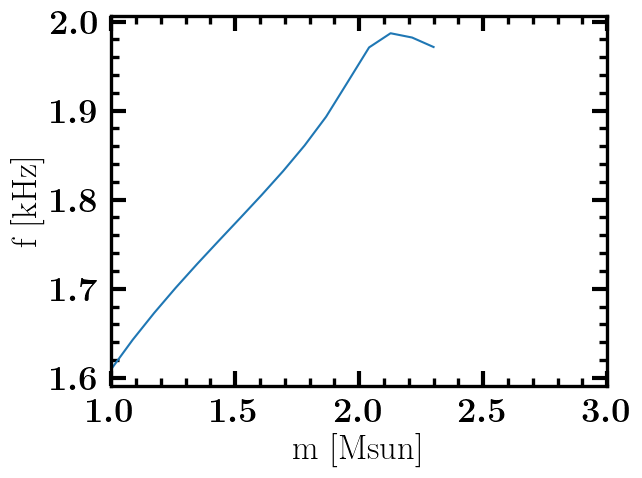

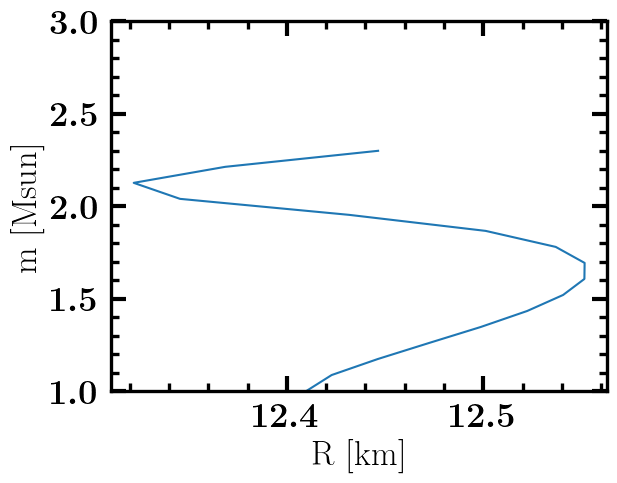

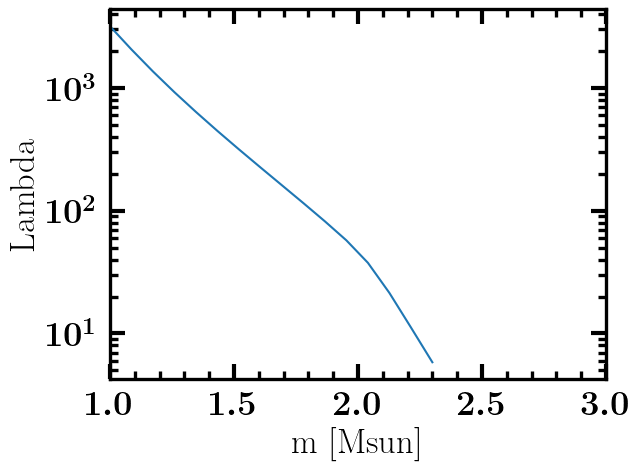

In [8]:
# plot mean f(m), R(m) and Lambda(m) relations

plt.plot(mApops,fApops)

plt.xlabel('m [Msun]')
plt.ylabel('f [kHz]')
plt.xlim(1.,3.)
plt.show()

plt.plot(RApops,mApops)

plt.ylabel('m [Msun]')
plt.xlabel('R [km]')
plt.ylim(1.,3.)
plt.show()

plt.plot(mApops,LApops)

plt.xlabel('m [Msun]')
plt.ylabel('Lambda')
plt.yscale('log')
plt.xlim(1.,3.)
plt.show()

In [9]:
# implement fmtidal phase model and define contact frequency

def Psi2(fgw,m1,m2,Lambda1,Lambda2,f1,f2): # m1, m2 in Msun, f1, f2 in Hz
    
    v = (G*(m1+m2)*Msun*np.pi*fgw)**(1./3.)
    
    X1 = m1/(m1+m2)
    X2 = m2/(m1+m2)
    eta = X1*X2

    Omega1 = G*m1*Msun*2.*np.pi*f1/c**3
    Omega2 = G*m2*Msun*2.*np.pi*f2/c**3
    
    quad1 = -(10*np.pi*np.sqrt(3.) - 27. - 30.*np.log(2.))*Lambda1*X1**6*(155.-147.*X1)*(v/c)**11/(96.*eta*Omega1**2)
    quad2 = -(10*np.pi*np.sqrt(3.) - 27. - 30.*np.log(2.))*Lambda2*X2**6*(155.-147.*X2)*(v/c)**11/(96.*eta*Omega2**2)
    
    return quad1+quad2

def Psi3(fgw,m1,m2,Lambdao1,Lambdao2,fo1,fo2):
    
    v = (G*(m1+m2)*Msun*np.pi*fgw)**(1./3.)
    
    X1 = m1/(m1+m2)
    X2 = m2/(m1+m2)
    eta = X1*X2
    
    Omegao1 = G*m1*Msun*2.*np.pi*fo1/c**3
    Omegao2 = G*m2*Msun*2.*np.pi*fo2/c**3
    
    oct1 = -1875.*(5.-6.*np.log(2))*LambdaOct1*X1**7*(v/c)**15/(16.*OmegaOct1**2)
    oct2 = -1875.*(5.-6.*np.log(2))*LambdaOct2*X2**7*(v/c)**15/(16.*OmegaOct1**2)
    
    return oct1+oct2

def fc(m1,m2,R1,R2): # in Hz
    
    return np.sqrt(G*(m1+m2)*Msun/(np.pi**2*(R1*1e5+R2*1e5)**3))

def Psi2c(m1,m2,R1,R2,Lambda1,Lambda2,f1,f2):
    
    return Psi2(fc(m1,m2,R1,R2),m1,m2,Lambda1,Lambda2,f1,f2)

/home/philippe.landry/bilby/bilby/gw/source.py:292: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


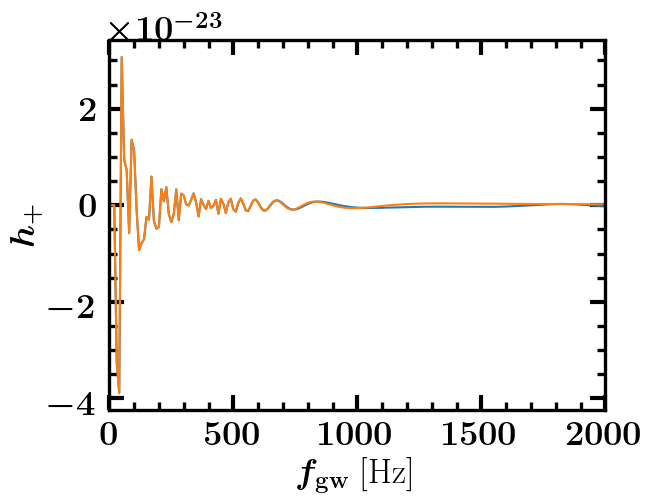

/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


RuntimeError: latex was not able to process the following string:
b'$h_{\\\\times}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpd1kljadx f864356235986bc3e48553957ad18777.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./f864356235986bc3e48553957ad18777.tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file f864356235986bc3e48553957ad18777.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
l.29 {\rmfamily $h_{\times}}
                            %
No pages of output.
Transcript written on tmpd1kljadx/f864356235986bc3e48553957ad18777.log.




<Figure size 640x480 with 1 Axes>

In [10]:
# augment TaylorF2_Tidal waveform model with dynamical tidal phase, and plot the + and x strains to compare

def TaylorF2_FMTidal(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, lambda_1, lambda_2, f_1, f_2, **kwargs):
    
    TaylorF2_Tidal = bilby.gw.source.lal_binary_neutron_star(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, lambda_1, lambda_2, **kwargs)    
    
    FMTidal = Psi2(frequency_array, mass_1, mass_2, lambda_1, lambda_2, f_1, f_2)
    
    return {'plus': TaylorF2_Tidal['plus']*np.exp(1j*FMTidal), 'cross': TaylorF2_Tidal['cross']*np.exp(1j*FMTidal)}

fgrid = np.arange(10.,2000.,10.)

plt.plot(fgrid,TaylorF2_FMTidal(fgrid,1.4,1.4,40.,0.,0.,0.,0.,0.,0.,0.,0.,390.,390.,1.4e3,1.4e3)['plus'])
plt.plot(fgrid,bilby.gw.source.lal_binary_neutron_star(fgrid,1.4,1.4,40.,0.,0.,0.,0.,0.,0.,0.,0.,390.,390.)['plus'])

plt.xlabel(r'$f_\mathrm{gw}$ [Hz]')
plt.ylabel(r'$h_+$')
plt.xlim(0.,2000.)
plt.show()

plt.plot(fgrid,TaylorF2_FMTidal(fgrid,1.4,1.4,40.,0.,0.,0.,0.,0.,0.,0.,0.,390.,390.,1.4e3,1.4e3)['cross'])
plt.plot(fgrid,bilby.gw.source.lal_binary_neutron_star(fgrid,1.4,1.4,40.,0.,0.,0.,0.,0.,0.,0.,0.,390.,390.)['cross'])

plt.xlabel(r'$f_\mathrm{gw}$ [Hz]')
plt.ylabel(r'$h_{\times}')
plt.xlim(0.,2000.)
plt.show()

In [11]:
# set up detector networks and injections

duration = 2048.
sampling_frequency = 2048.
minimum_frequency = 10.

waveform_arguments = dict(
    waveform_approximant="TaylorF2", #"IMRPhenomPv2_NRTidal",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=TaylorF2_FMTidal, #bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

In [12]:
event_snrs_hlv = np.full((len(mApops),len(mBpops)),np.inf)
event_snrs_aplus = np.full((len(mApops),len(mBpops)),np.inf)
event_snrs_xg = np.full((len(mApops),len(mBpops)),np.inf)
event_snrs_xg2 = np.full((len(mApops),len(mBpops)),np.inf)
event_dsts_hlv = np.full((len(mApops),len(mBpops)),np.inf)
event_dsts_aplus = np.full((len(mApops),len(mBpops)),np.inf)
event_dsts_xg = np.full((len(mApops),len(mBpops)),np.inf)
event_dsts_xg2 = np.full((len(mApops),len(mBpops)),np.inf)

event_dsts_dict = {'hlv': event_dsts_hlv, 'aplus': event_dsts_aplus, 'xg': event_dsts_xg, 'xg2': event_dsts_xg2}
event_snrs_dict = {'hlv': event_snrs_hlv, 'aplus': event_snrs_aplus, 'xg': event_snrs_xg, 'xg2': event_snrs_xg2}

for i,(mA,fA,LA) in tqdm(enumerate(zip(mApops,fApops,LApops))):
    for j,(mB,fB,LB) in enumerate(zip(mBpops,fBpops,LBpops)):

        if mB > mA: continue

        injection_parameters1 = dict(
            mass_1=mA,
            mass_2=mB,
            chi_1=0.0,
            chi_2=0.0,
            luminosity_distance=100.0, # checked distinguishability independent of distance
            theta_jn=0.,
            psi=2.659,
            phase=1.3,
            geocent_time=1126259642.413,
            ra=1.375,
            dec=-1.2108,
            lambda_1=LA,
            lambda_2=LB,
            f_1=100e3, # set impossibly high to negate effect
            f_2=100e3
        )
    
        injection_parameters2 = dict(
            mass_1=mA,
            mass_2=mB,
            chi_1=0.0,
            chi_2=0.0,
            luminosity_distance=100.0,
            theta_jn=0., # optimally oriented
            psi=2.659,
            phase=1.3,
            geocent_time=1126259642.413,
            ra=1.375,
            dec=-1.2108,
            lambda_1=LA,
            lambda_2=LB,
            f_1=fA*1e3,
            f_2=fB*1e3
        )
        
        for network in ('hlv','aplus','xg','xg2'):
            
            ifos = []
            
            if network == 'hlv': 
                ifos = bilby.gw.detector.InterferometerList(["H1"])#,"L1","V1"])

            elif network == 'aplus':
                ifos = bilby.gw.detector.InterferometerList(["H1"])#,"L1","V1"])
                for ifo in ifos[:1]: ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file='/home/philippe.landry/bilby/bilby/gw/detector/noise_curves/Aplus_asd.txt')

            elif network == 'xg':
                ifos = bilby.gw.detector.InterferometerList(["H1"])#,"L1","ET"])
                ifos[0].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file='./ce/cosmic_explorer_strain.txt')
                #ifos[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file='./ce/cosmic_explorer_20km_strain.txt')

            elif network == 'xg2':
                ifos = bilby.gw.detector.InterferometerList(["ET"])
                #ifos[0].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file='./ce/cosmic_explorer_strain.txt')
                #ifos[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(asd_file='./ce/cosmic_explorer_20km_strain.txt')
                
            net_snrs = []
            opt_snr_sqs_ifos = []
            signals_ifos = []
                
            for injection_parameters in (injection_parameters1,injection_parameters2):

                ifos.set_strain_data_from_power_spectral_densities(
                    sampling_frequency=sampling_frequency,
                    duration=duration,
                    start_time=injection_parameters["geocent_time"] - 2
                )

                pols = ifos.inject_signal(
                    waveform_generator=waveform_generator, parameters=injection_parameters
                )

                signal_ifos = [ifo.get_detector_response(pols[i], ifo.meta_data['parameters']) for i,ifo in enumerate(ifos)]
                frequencies_ifos = [ifo.strain_data._times_and_frequencies._frequency_array[ifo.strain_data._times_and_frequencies._frequency_array >= min(ifo.power_spectral_density.frequency_array)] for ifo in ifos]
                psd_ifos = [interp1d(ifo.power_spectral_density.frequency_array,ifo.power_spectral_density.psd_array)(frequencies_ifos[i]) for i,ifo in enumerate(ifos)]
                signal_ifos = [signal_ifos[i][np.where(ifo.strain_data._times_and_frequencies._frequency_array >= min(ifo.power_spectral_density.frequency_array))[0][0]:] for i,ifo in enumerate(ifos)]
                opt_snr_sq_ifos = [bilby.gw.utils.noise_weighted_inner_product(signal_ifos[i],signal_ifos[i],psd_ifos[i],duration).real for i,ifo in enumerate(ifos)]
                net_snr = np.sqrt(np.sum(opt_snr_sq_ifos))

                net_snrs += [net_snr]
                opt_snr_sqs_ifos += [opt_snr_sq_ifos]
                signals_ifos += [signal_ifos]

            dst_snr_sq_ifos = [3./(1.-bilby.gw.utils.noise_weighted_inner_product(signals_ifos[0][i],signals_ifos[1][i],psd_ifos[i],duration).real/np.sqrt(opt_snr_sqs_ifos[0][i]*opt_snr_sqs_ifos[1][i])) for i,ifo in enumerate(ifos)]
            dst_snr = np.sqrt(np.sum(dst_snr_sq_ifos))

            event_snrs_dict[network][i,j] = net_snrs[1]
            event_dsts_dict[network][i,j] = dst_snr

16it [1:45:46, 396.67s/it]


/tmp/ipykernel_1522356/3747280463.py:9: RuntimeWarning: invalid value encountered in divide
  cfs1 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_hlv.T/event_dsts_hlv.T,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)
/tmp/ipykernel_1522356/3747280463.py:12: RuntimeWarning: invalid value encountered in divide
  cfs2 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_aplus/event_dsts_aplus,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)


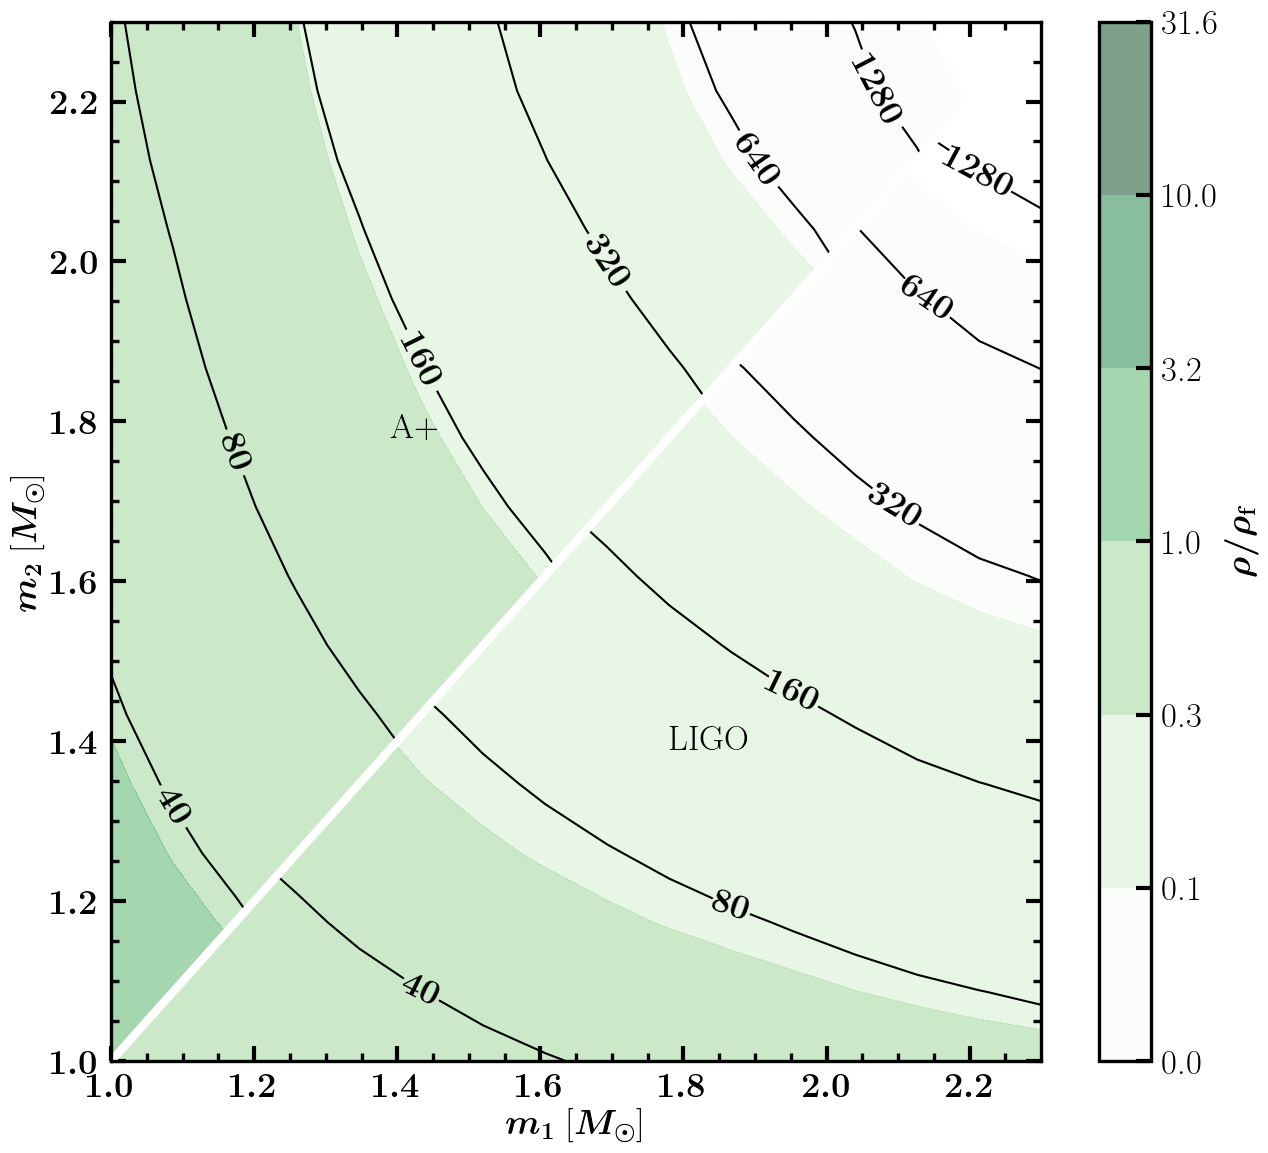

In [57]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

levels = [10.**(-1.5),10.**(-1),10.**(-0.5),10.**0,10.**0.5,10.**1,10.**1.5] #[10.**(-2),10.**(-1.5),10.**(-1),10.**(-0.5),10.**0,10.**0.5,10.**1,10.**1.5,10.**2]
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

dist_levels = [40.,80.,160.,320.,640.,1280.]

cfs1 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_hlv.T/event_dsts_hlv.T,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)
cs1 = plt.contour(mApops,mBpops,np.nan_to_num(event_dsts_hlv.T,posinf=np.nan),colors='k',levels=dist_levels)

cfs2 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_aplus/event_dsts_aplus,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)
cs2 = plt.contour(mApops,mBpops,np.nan_to_num(event_dsts_aplus,posinf=np.nan),colors='k',levels=dist_levels)

plt.plot([1.,2.3],[1.,2.3],c='white',lw=6)

plt.clabel(cs1, inline=True)
cbar = plt.colorbar(cfs1,cmap='Greens',location='right',shrink=1,anchor=(0.,0.),format='%1.1f')

plt.clabel(cs2, inline=True)
#plt.colorbar(cfs2,cmap='Greens',location='top',aspect=20./0.8,label=r'$\mathrm{A+}~\rho_\mathrm{f}/\rho$')

plt.text(1.+0.6*1.3,1.+0.3*1.3,'LIGO')
plt.text(1.+0.3*1.3,1.+0.6*1.3,'A+')

plt.xlim(1.,2.3)
plt.ylim(1.,2.3)
plt.xlabel(r'$m_1$ [$M_\odot$]')
plt.ylabel(r'$m_2$ [$M_\odot$]')
cbar.set_label(label=r'$\rho/\rho_\mathrm{f}$')
#cbar.ax.set_yticklabels(weight='bold', labels=['{0:.1f}'.format(lbl) for lbl in [0.03,0.10,0.32,1.,3.16,10.,31.62]])
plt.savefig('distinguishability_ligo.png')

/tmp/ipykernel_1522356/2494967881.py:3: RuntimeWarning: invalid value encountered in divide
  cfs1 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_xg2.T/event_dsts_xg2.T,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)
/tmp/ipykernel_1522356/2494967881.py:6: RuntimeWarning: invalid value encountered in divide
  cfs2 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_xg/event_dsts_xg,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)


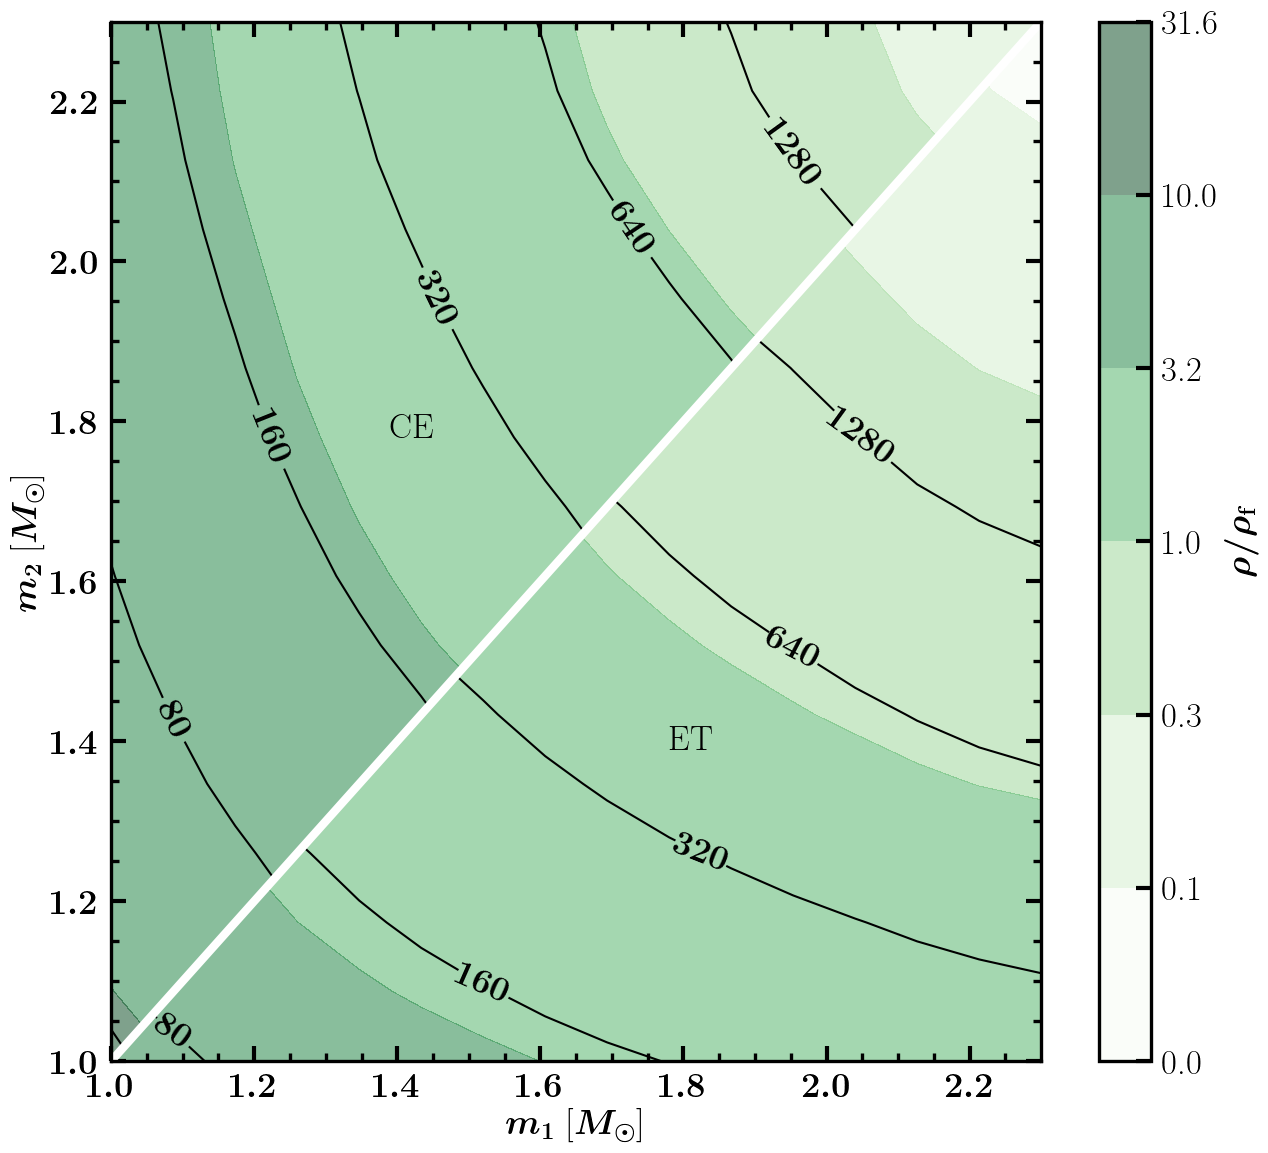

In [58]:
fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

cfs1 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_xg2.T/event_dsts_xg2.T,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)
cs1 = plt.contour(mApops,mBpops,np.nan_to_num(event_dsts_xg2.T,posinf=np.nan),colors='k',levels=dist_levels)

cfs2 = plt.contourf(mApops,mBpops,np.nan_to_num(event_snrs_xg/event_dsts_xg,nan=np.nan),alpha=0.5,cmap='Greens',levels=levels,norm=norm)
cs2 = plt.contour(mApops,mBpops,np.nan_to_num(event_dsts_xg,posinf=np.nan),colors='k',levels=dist_levels)

plt.plot([1.,2.3],[1.,2.3],c='white',lw=6)

plt.clabel(cs1, inline=True)
cbar = plt.colorbar(cfs1,cmap='Greens',location='right',shrink=1,anchor=(0.,0.),format='%1.1f')

plt.clabel(cs2, inline=True)
#plt.colorbar(cfs2,cmap='Greens',location='top',aspect=20./0.8,label=r'$\mathrm{CE}~\rho_\mathrm{f}/\rho$')

plt.text(1.+0.6*1.3,1.+0.3*1.3,'ET',weight='bold')
plt.text(1.+0.3*1.3,1.+0.6*1.3,'CE',weight='bold')

plt.xlim(1.,2.3)
plt.ylim(1.,2.3)
plt.xlabel(r'$m_1$ [$M_\odot$]')
plt.ylabel(r'$m_2$ [$M_\odot$]')
cbar.set_label(label=r'$\rho/\rho_\mathrm{f}$')
plt.savefig('distinguishability_ceet.png')

In [56]:
print(mApops[5],mBpops[5])
print(event_dsts_hlv[5,5],event_dsts_aplus[5,5],event_dsts_xg2[5,5],event_dsts_xg[5,5])

1.4333333333333333 1.4333333333333333
76.14352823659874 88.35502227243929 271.7085166752661 154.2447595189805
